<a href="https://colab.research.google.com/github/nrajmalwar/Project/blob/master/Phase%202%20Session%205/Assignment_P2S5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import PIL

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       # Random rotate transform augmentation
                                       transforms.RandomRotation(10, fill=(0,)),
                                       transforms.ToTensor(),                                      
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)                                                                            
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([ transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([128, 1, 28, 28])
torch.Size([128])


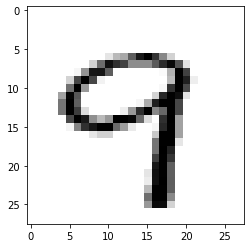

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

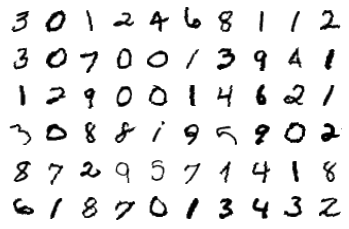

In [9]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(24),
            nn.Dropout(p=0.1),
            nn.ReLU()
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(24),
            nn.Dropout(p=0.1),
            nn.ReLU()
        ) # output_size = 10

        # Dropout

        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 5
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        # CONVOLUTION BLOCK 6
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=28, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(28),
            nn.Dropout(p=0.1),
            nn.ReLU()
        ) # output_size = 3

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=28, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool2(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        
        # print(x.shape)
        x = x.view(-1, 10)
        # print(x.shape)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [11]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 24, 24, 24]           3,456
       BatchNorm2d-5           [-1, 24, 24, 24]              48
           Dropout-6           [-1, 24, 24, 24]               0
              ReLU-7           [-1, 24, 24, 24]               0
         MaxPool2d-8           [-1, 24, 12, 12]               0
            Conv2d-9           [-1, 16, 12, 12]             384
      BatchNorm2d-10           [-1, 16, 12, 12]              32
             ReLU-11           [-1, 16, 12, 12]               0
           Conv2d-12           [-1, 24, 10, 10]           3,456
      BatchNorm2d-13           [-1, 24, 10, 10]              48
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [13]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# Use StepLR
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    # Apply StepLR
    scheduler.step()

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.046553339809179306 Batch_id=468 Accuracy=93.69: 100%|██████████| 469/469 [00:11<00:00, 40.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0752, Accuracy: 9788/10000 (97.88%)

EPOCH: 1


Loss=0.0581265427172184 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:12<00:00, 39.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0571, Accuracy: 9818/10000 (98.18%)

EPOCH: 2


Loss=0.06450561434030533 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:12<00:00, 38.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9893/10000 (98.93%)

EPOCH: 3


Loss=0.05621136724948883 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:12<00:00, 38.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9887/10000 (98.87%)

EPOCH: 4


Loss=0.04621697962284088 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:12<00:00, 39.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9895/10000 (98.95%)

EPOCH: 5


Loss=0.05785331502556801 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:11<00:00, 39.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9912/10000 (99.12%)

EPOCH: 6


Loss=0.01398239005357027 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 34.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9932/10000 (99.32%)

EPOCH: 7


Loss=0.08880779892206192 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 35.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9931/10000 (99.31%)

EPOCH: 8


Loss=0.04600800201296806 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 37.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.004122093319892883 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:12<00:00, 37.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.008146986365318298 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:12<00:00, 37.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.026595095172524452 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 38.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.03243257477879524 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 37.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.04487502574920654 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:12<00:00, 37.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.041474681347608566 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 37.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.030330633744597435 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:12<00:00, 37.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.04995685815811157 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 37.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9937/10000 (99.37%)

EPOCH: 17


Loss=0.02392660640180111 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 37.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.00563425337895751 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:12<00:00, 37.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9931/10000 (99.31%)

EPOCH: 19


Loss=0.0017953813076019287 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 37.38it/s]



Test set: Average loss: 0.0234, Accuracy: 9931/10000 (99.31%)



Text(0.5, 1.0, 'Test Accuracy')

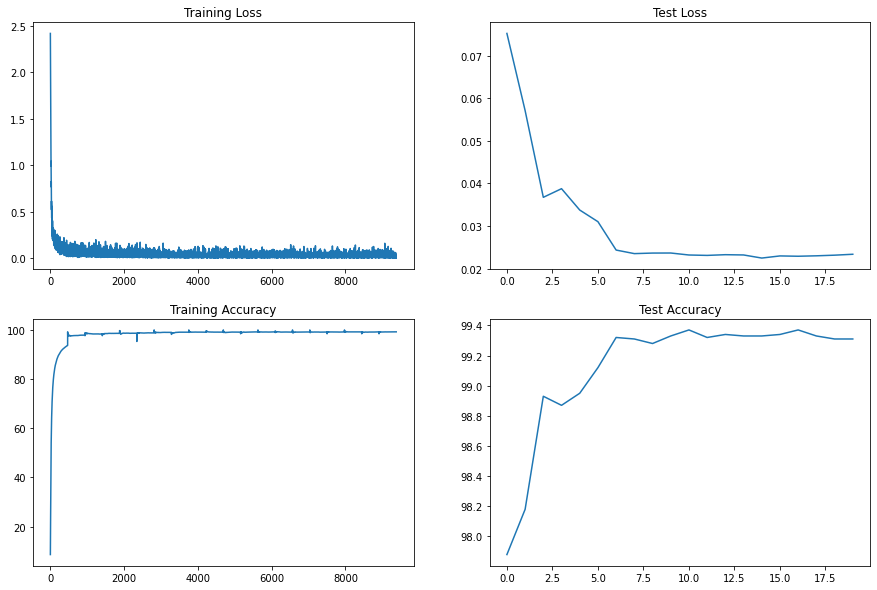

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Achieved highest Test Accuracy of 99.37% at Epoch no. 10